# Learning MN classifier of label sequences

This example shows how to learn a linear Markov Network classifier that outputs a sequence of labels
$$
   (\hat{y}_0,\ldots,\hat{y}_{l-1})\in arg\max_{(y_0,\ldots,y_{l-1})\in \cal{Y}^{l}} \left( \sum_{v=0}^{l-1} \mathbf{x}_v^T\mathbf{w}_{y_v} + \sum_{v=1}^{l-1} g(y_{v-1},y_v) \right )
$$
where $\cal{Y}=\{0,1,\ldots,n_y-1\}$ is set of $n_y$ labels, $l$ is length of the sequence, $(\mathbf{x}_0,\ldots,\mathbf{x}_{l-1})\in\Re^{n\times l}$ is a sequence of input feature vectors, $(\hat{y}_0,\ldots,\hat{y}_{l-1})\in\cal{Y}^l$ is predicted sequence of labels, $\mathbf{w}_y\in\Re^n$, $y\in\cal{Y}$, are weight vectors and $g\colon\cal{Y}\times\cal{Y}\rightarrow\Re$ is a function scoring quality of a pair of consecutive labels. The weight vectors $\mathbf{w}_y\in\Re^n$, $y\in\cal{Y},$ and the pair-wise score $g\colon\cal{Y}\times\cal{Y}\rightarrow\Re$ are the parameters to be learned from examples.

This example shows how to learn the parameters from completly annotated sequences (standard supervised learning):
$$
   \{ ((\mathbf{x}_0^j,\ldots,\mathbf{x}_{l-1}^j), (y_0^j,\ldots,y_{l-1}^j))\in \Re^{n\times l}\times \cal{Y}^l  \mid j = 1,\ldots, m \}
$$
However, we also show how learn the parameters from partially annoated examples when some labels in the training set are missing:
$$
   \{ ((\mathbf{x}_0^j,\ldots,\mathbf{x}_{l-1}^j), (y_0^j,\ldots,y_{l-1}^j))\in \Re^{n\times l}\times (\cal{Y}\cup \{?\})^l  \mid j = 1,\ldots, m \}
$$
The algorithm implemented in MANET is guaranteed to work under assumption that the labels are missing at random.

The objective is to learn MN predictor with minimal expected Hamming loss. Becasue the Hamming loss is hard to optimize as its gradient is zero almost everywhere, the M3N algorithm replaces the target Hamming loss by easier to optimize proxy loss. MANET implements two proxy losses: i) LP Margin-Rescaling loss and ii) MArkov Network Adversarial (MANA) loss.

In this example, the input/output sequences are generated from a known Hidden Markov Chain model. Hence, we can estimate the Bayes risk and use it as a reference solution when evaluating the MN predictor learned from data.

# Define data generator

We will use synthetic data generated from a Hidden Markov Chain. The observable sequence $(x_0,\ldots,x_{l-1})\in \{0,\ldots,n_x-1\}^l$ and the hidden sequence $(y_0,\ldots,y_{l-1})\in \{0,\ldots,n_y-1\}^l$ follow the distribution:
$$ P(x_0,\ldots,x_{l-1},y_0,\ldots,y_{l-1})=P_0(y_0)\prod_{i=1}^{l-1} P(y_i\mid y_{i-1}) P(x_i\mid y_i)$$

In this code we set the transition probability to
$$P(y_{i+1}\mid y_i) = \left \{ \begin{array}{lll}
   \alpha & if & y_{i+1} = y_i\\
   (1-\alpha)/(n_y-1) & if & y_{i+1} \neq y_i
  \end{array}
  \right .
$$
and the emission probability to
$$P(x_i\mid y_i) = \left \{ \begin{array}{lll}
   \beta & if & x_i = y_i\\
   (1-\beta)/(n_x-1) & if & x_i \neq y_i
  \end{array}
  \right .
$$

The number of observeble symbols $n_x$, hidden symbols $n_y$, the initial state probability $P_0(y_0)$, the numbers $\alpha\in(0,1)$, $\beta\in(0,1)$ and the sequence length $l$ are hyperparameters that can be defined below. 

In the following example, the sequence length is kept constant, however note that MANET allows the length of training examples to be different.

In [1]:
import numpy as np
from manet.hmc import HMC

n_x = 30        # number of observable symbols
n_y = 10        # number of hidden symbols
alpha = 0.7     # hyperparameter of the transition probability
beta = 0.7      # hyperparameter of the emission probability
seq_length = 10 # sequence length

# define transition probability
trans = (1-beta)*np.ones((n_y,n_y)) / (n_y-1)
np.fill_diagonal( trans, beta )

# define emission probability
emis = (1-alpha)*np.ones( (n_y,n_x )) / (n_x - 1)
np.fill_diagonal( emis, alpha )

# define initial state probability
p0 = np.ones( n_y ) / n_y

# initialize HMC class
Hmc = HMC( p0, trans, emis, alphabet=np.int16)

# Estimate Bayes risk

Because we know the data distribution, we can construct Bayes optimal rule. We construct the Bayes rule that minimizes the expected Hamming loss 
$$
  \ell_{Hamming}(y_0,\ldots,y_{l-1},\hat{y}_0,\ldots,\hat{y}_{l-1}) = \frac{1}{l}\sum_{i=1}^{l-1}\delta(y_i\neq \hat{y}_i)
$$
and the Bayes rule that minimizes the expected 0/1-loss
$$
  \ell_{0/1}(y_0,\ldots,y_{l-1},\hat{y}_0,\ldots,\hat{y}_{l-1}) = \left \{
    \begin{array}{ll}
      1 & if \; \lor_{i=1}^{l-1}\delta(y_i\neq \hat{y}_i)\\
      0 & otherwise
      \end{array}
      \right .
$$
In case of Hamming loss, the Bayes rule is a sequence of the most probable states which can be computed by function <code>HMC.decode</code>. In case of 0/1l-loss, the Bayes rule is a sequence maximizing a posteriory probability which can be computed by function <code>HMC.map</code>. Having the Bayes rules, we estimate the Bayes risk (best attainable) to get a reference solution for later comparison with the rule learned from examples by M3N algorithm. The implemented M3N algorithm minimizes only a proxy of the Hamming loss.

In [2]:
m = 10000 # number of examples used to estimate the Bayes risk

risk_hamming_decode = 0  # Expected Hamming loss of max-marginals (decode) rule
risk_01_map = 0          # Expected 0/1-loss of MAP rule
for i in range( m ):
    X, Y = Hmc.generate( seq_length )

    # Maximum aposteriory rule
    Ymap, log_map = Hmc.map(X)
    risk_01_map += int( np.any( Y != Ymap ) )

    # Decode rule i.e. sequnce of the most probable states
    P = Hmc.decode( X )
    Ydec = np.argmax( P, axis = 0)
    risk_hamming_decode += np.count_nonzero( Y-Ydec ) / seq_length
    
risk_01_map /= m
risk_hamming_decode /= m
    
print("Bayes risk for Hamming loss:", risk_hamming_decode)
print("bayes risk for 0/1-loss:", risk_01_map)

Bayes risk for Hamming loss: 0.15619999999999737
bayes risk for 0/1-loss: 0.7453


# Learning from completly annotated examples

We use the Hidden Markov Chain model to generate set of training sequences and testing sequences. We first consider training from complete label sequences, i.e. there are no missing labels.

In [3]:
# define number of ttraining and test examples
n_trn_examples = 500 
n_tst_examples = 500
def generate_sequences( Hmc, length, n_examples):
    examples = []
    for i in range( n_examples):
        X, Y = Hmc.generate(  length )
        examples.append({'X': X, 'Y': Y, 'n_x': Hmc.n_x, 'n_y': Hmc.n_y} )
    return examples        

trn_sequences = generate_sequences( Hmc, seq_length, n_trn_examples)
tst_sequences = generate_sequences( Hmc, seq_length, n_tst_examples)

trn_sequences[0]

{'X': array([ 1,  1, 19, 20,  2,  2,  4,  4,  4,  6], dtype=int16),
 'Y': array([1, 1, 4, 2, 2, 2, 4, 4, 4, 6], dtype=int16),
 'n_x': 30,
 'n_y': 10}

We represent each training example as a Markov Network whose input is the observable sequence. The class implementing the Markov Network allows i) to predict the sequence of labels and ii) to evaluate the proxy of the Hamming loss and its gradient which is used when learning parameters of the MN predictor. MANET implements two models which differ in the used proxy: i) the Margin-rescaling loss (class <code>MrMaNetHomo</code>)and ii) MArkov Network Adversarial loss (class <code>AdvMaNetHomo</code>). The models assume the input observations to be real-valued feature vectors, hence, in this example the symbols of the input sequences are one-hot encoded. The models work for arbitrary graph of interactions, however, in this example the edges of the graph are set to be a simple chain.


In [4]:
from manet.m3n import M3N, one_hot
from manet.mn_models import MrMaNetHomo, AdvMaNetHomo

def create_markov_nets( model, sequences ):
    examples = []
    for seq in sequences:
        length = len( seq['X'])        
        chain = np.concatenate(( np.arange(0,length-1).reshape((1,length-1)),
                                 np.arange(1,length).reshape((1,length-1)) ),axis=0)
        examples.append( model( n_y = seq['n_y'],\
                            X = one_hot(seq['n_x'],seq['X']),\
                            Y = seq['Y'],\
                            E = chain, \
                            graph = 'chain') )
    return examples

# select which proxy of the Hamming loss is going to be used
model = MrMaNetHomo   # use Margin-recaling proxy
#model = AdvMaNetHomo # use MANA loss

trn_examples = create_markov_nets( model, trn_sequences)
tst_examples = create_markov_nets( model, tst_sequences)

We use stochastic gradient solver to minimize L2-regularized proxy of the Hamming loss (Margin-Rescaling or MANA) on training examples. The strength of L2-regularization is a hyperpameter (<code>lam</code>). The MANET implements a plain Stochastic Gradient Descend (SGD) and ADAM (<code>solver</code>). The algorithm runs for a fixed number of passes through training examples (<code>num_epochs</code>). The learning rate $\alpha_t$ at epoch $t$ is set to 
$$
   \alpha_{t} = A(t+1)^B
$$
where $A$ and $B$ are hyperparameters. The solver returns a vector <code>params</code> which encapsulates parameters $\mathbf{w}_y\in\Re^n$, $y\in\cal{Y}$, and $g\colon\cal{Y}\times\cal{Y}\rightarrow\Re$ of the MN predictor.

epoch=0 obj_val=0.9272982448751459
epoch=10 obj_val=0.4963930285339164
epoch=20 obj_val=0.43220319213721986
epoch=30 obj_val=0.41109246162454505
epoch=40 obj_val=0.4014600185445441
epoch=50 obj_val=0.3946232028035921
epoch=60 obj_val=0.39086565445948157
epoch=70 obj_val=0.38827788095176313
epoch=80 obj_val=0.38680813743013903
epoch=90 obj_val=0.3851299513169953
epoch=99 obj_val=0.3843592444110392


Text(0, 0.5, 'objective')

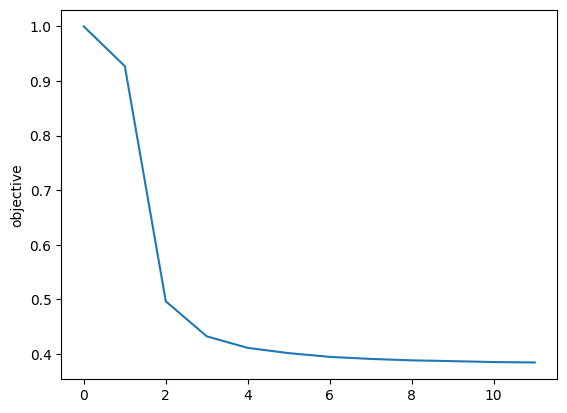

In [5]:
import matplotlib.pyplot as plt

config = {'num_epochs': 100,  # number of passes over training examples
          'lr_const': 0.01,   # hyperparamter A
          'lr_exp': -1,       # hyperparamter B
          'eval_obj': 10,     # frequency of evaluation of the objective function 
          'verb': True,       # display progress
          'solver': 'adam'}   # solver "adam" or "sgd"
 
algo = M3N( config )

lam = 0 # regularization parameter
params, obj_val = algo.train( trn_examples, lam )

plt.figure()
plt.plot(obj_val)
plt.ylabel("objective")

We evaluate training and test error and compare agains the error of Bayes predictor. Recall that M3N aims to minimize a proxy of the Hamming loss.

In [7]:
trn_hamming_loss, trn_01_loss = algo.eval( params, trn_examples )
trn_risk_hamming_m3n = np.mean(trn_hamming_loss)
trn_risk_01_m3n = np.mean(trn_01_loss)

print("[MN predictor]")
print("Training error")
print( "Hamming loss:",trn_risk_hamming_m3n)
print( "01-loss:", trn_risk_01_m3n )

tst_hamming_loss, tst_01_loss = algo.eval( params, tst_examples )
tst_risk_hamming_m3n = np.mean(tst_hamming_loss)
tst_risk_01_m3n = np.mean(tst_01_loss)

print("Test error")
print( "Hamming loss:",tst_risk_hamming_m3n)
print( "01-loss:", tst_risk_01_m3n)

print()
print("[Test error of Bayes predictor]")
print( "Hamming loss:", risk_hamming_decode)
print( "01 loss:", risk_01_map)

[MN predictor]
Training error
Hamming loss: 0.17120000000000002
01-loss: 0.798
Test error
Hamming loss: 0.184
01-loss: 0.818

[Test error of Bayes predictor]
Hamming loss: 0.15619999999999737
01 loss: 0.7453


The following code shows some predictions on test examples.

In [8]:
for i in range(10):
    Y_pred, score = algo.predict( params, tst_examples[i] )

    print("example:", i)
    print("predictor score   :", score )
    print("input sequnce     :", tst_sequences[i]['X'])
    print("true sequence     :", tst_sequences[i]['Y'] )
    print("predicted sequence:",Y_pred )

example: 0
predictor score   : 3.4840696078171978
input sequnce     : [28  9  9  3  3  3 23  3  3  3]
true sequence     : [9 9 9 3 3 3 3 3 3 3]
predicted sequence: [9 9 9 3 3 3 3 3 3 3]
example: 1
predictor score   : 3.343106245589225
input sequnce     : [ 1  4 16  8  1  8  8  8  0  0]
true sequence     : [9 9 9 8 8 8 8 8 0 0]
predicted sequence: [1 4 4 8 1 8 8 8 0 0]
example: 2
predictor score   : 3.1801161697904243
input sequnce     : [23  2 10  0  0  8  4  2  2  0]
true sequence     : [1 1 1 0 0 8 2 2 2 0]
predicted sequence: [2 2 2 0 0 8 4 2 2 0]
example: 3
predictor score   : 3.0993182837087776
input sequnce     : [27  9  9 11  1  1 16  9  4  4]
true sequence     : [9 9 9 9 1 1 7 4 4 4]
predicted sequence: [9 9 9 1 1 1 9 9 4 4]
example: 4
predictor score   : 3.134699976074608
input sequnce     : [ 7  1  1 23  1 23 11  4  4  7]
true sequence     : [7 1 1 1 1 1 1 4 4 7]
predicted sequence: [7 1 1 1 1 4 4 4 4 7]
example: 5
predictor score   : 3.49596692692834
input sequnce     : [19 

# Learning from examples with missing labels

We use the Hidden Markov Chain model to generate set of training sequences and testing sequences. A randomly selected portion of labels in the training sequences are changed to be uknown (special label -1). The portion of missing labels is defined by <code>p_missing</code>. Note that the learning algorithm does not need to known the portion of missing labels, however it relies on the assumption that the labels are missing at random.

In [9]:
# define number of training and test examples
n_trn_examples = 500 # number of 
n_tst_examples = 500

# define portion of missing labels
p_missing = 0.2

def generate_sequences( Hmc, length, n_examples, p_missing):
    examples = []
    for i in range( n_examples):
        X, Y = Hmc.generate(  length )

        # randomly selected a subset of labels and change them to unknowns
        missing = np.random.choice( 2, length, p=[1-p_missing,p_missing] )
        Y[missing==1] = -1

        examples.append({'X': X, 'Y': Y, 'n_x': Hmc.n_x, 'n_y': Hmc.n_y} )
    return examples        

trn_sequences_missing = generate_sequences( Hmc, seq_length, n_trn_examples, p_missing)
trn_sequences_missing[0]

{'X': array([ 3, 18,  3,  3,  3,  6,  6,  6,  0,  7], dtype=int16),
 'Y': array([ 3,  3,  3,  3,  6, -1,  6,  6,  6,  7], dtype=int16),
 'n_x': 30,
 'n_y': 10}

Training on from examples with missing labels is the same as in the case of complete annotations. The only difference is that the learning algorithm needs to know type of the process which generated the missing labels. There are two options supported: i) probability of missing label is the same for each object in the sequence (denoted as <code>homo</code>-geneous annotations) or ii) the probability can be different for each object in the sequence (<code>unhomo</code>-geneous annotations). Note that the algorithm does not require to know the probabilities but only whether they are the same or different. 

epoch=0 obj_val=0.9919691402877069
epoch=10 obj_val=0.5363907432873647
epoch=20 obj_val=0.46282813862131955
epoch=30 obj_val=0.43438351614677795
epoch=40 obj_val=0.41736179793012346
epoch=50 obj_val=0.40675856340841776
epoch=60 obj_val=0.3993072741350134
epoch=70 obj_val=0.394413796045726
epoch=80 obj_val=0.38952141307869154
epoch=90 obj_val=0.3859297059481015
epoch=99 obj_val=0.3830540911703365


Text(0, 0.5, 'objective')

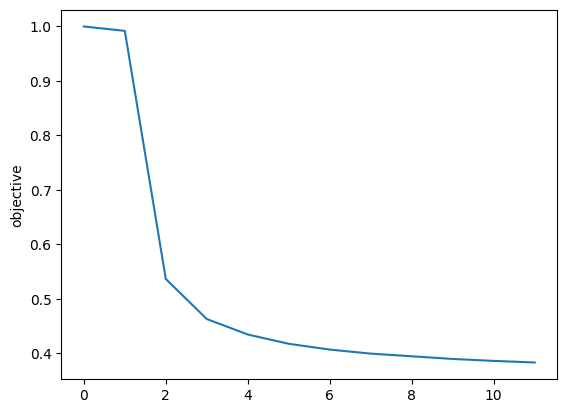

In [10]:
trn_examples_missing = create_markov_nets( model, trn_sequences_missing)

config = {'num_epochs': 100,    # number of passes over training examples
          'lr_const': 0.01,     # hyperparamter A
          'lr_exp': -1,         # hyperparamter B
          'eval_obj': 10,       # frequency of evaluation of the objective function 
          'verb': True,         # display progress
          'solver': 'adam',     # solver "adam" or "sgd"
          'annotation': 'homo'} # type of missingness "home"-geneous or "unhomo"-geneous
 
algo = M3N( config )

lam = 0
params_missing, obj_val = algo.train( trn_examples_missing, lam )

plt.figure()
plt.plot(obj_val)
plt.ylabel("objective")

Finaly, we evaluate performance of the MN predictor trained from examples with missing labels and compare to the one trained from complete annotations and to the Bayes predictor. Note that the training errors of the predictor trained from missing labels is lower because the missing labels do not contribute to the training error as they are unknown. 

In [11]:
trn_hamming_loss_mis, trn_01_loss_mis = algo.eval( params_missing, trn_examples_missing )
trn_risk_hamming_m3n_mis = np.mean(trn_hamming_loss_mis)
trn_risk_01_m3n_mis = np.mean(trn_01_loss_mis)

tst_hamming_loss_mis, tst_01_loss_mis = algo.eval( params_missing, tst_examples )
tst_risk_hamming_m3n_mis = np.mean(tst_hamming_loss_mis)
tst_risk_01_m3n_mis = np.mean(tst_01_loss_mis)


print(f"[MN predictor trained from examples with {p_missing*100}% of missing labels]")
print("Training errors")
print("Hamming loss:",trn_risk_hamming_m3n_mis)
print("01-loss:", trn_risk_01_m3n_mis )
print("Test errors")
print("Hamming loss:",tst_risk_hamming_m3n_mis)
print("01-loss:", tst_risk_01_m3n_mis )

print()
print(f"[MN predictor trained from complete examples]")
print("Training errors")
print("Hamming loss:",trn_risk_hamming_m3n)
print("01-loss:", trn_risk_01_m3n )
print("Test errors")
print("Hamming loss:",tst_risk_hamming_m3n)
print("01-loss:", tst_risk_01_m3n )

print()
print("[Test error of Bayes predictor]")
print( "Hamming loss:", risk_hamming_decode)
print( "01 loss:", risk_01_map)

[MN predictor trained from examples with 20.0% of missing labels]
Training errors
Hamming loss: 0.11720000000000001
01-loss: 0.664
Test errors
Hamming loss: 0.18760000000000002
01-loss: 0.828

[MN predictor trained from complete examples]
Training errors
Hamming loss: 0.17120000000000002
01-loss: 0.798
Test errors
Hamming loss: 0.184
01-loss: 0.818

[Test error of Bayes predictor]
Hamming loss: 0.15619999999999737
01 loss: 0.7453
